In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.2.0-rc1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os

import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.models import Model, load_model
from keras.layers import *
from keras.layers.merge import concatenate

from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import notebook

### Đọc dữ liệu

In [ ]:
im_height = 256
im_width = 256

In [ ]:
import os
ids = next(os.walk("/content/drive/MyDrive/KLTN/data_unet/train_isbi/image"))[2] # list of names all images in the given path
print("Số lượng ảnh = ", len(ids))

Số lượng ảnh =  90


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = np.array(Image.open("/content/drive/MyDrive/KLTN/data_unet/train_isbi/image/"+id_).convert('L'))
    x_img = resize(img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = np.array(Image.open("/content/drive/MyDrive/KLTN/data_unet/train_isbi/label/"+id_).convert('L'))
    x_mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = x_mask/255.0

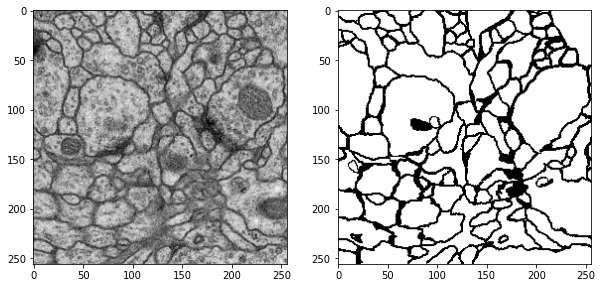

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(X[0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.imshow(y[0].squeeze(), cmap = 'gray', interpolation = 'bilinear')

In [ ]:
# chia dữ liệu thành 2 phần 80-20
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print("X train: ", len(X_train))
print("y train: ", len(y_train))
print("X valid: ", len(X_valid))
print(X_train[1].shape)
print(y_train[1].shape)
print(type(X_train[0][0][0][0]))

X train:  72
y train:  72
X valid:  18
(256, 256, 1)
(256, 256, 1)
<class 'numpy.float32'>


### Định nghĩa các khối

In [ ]:
# relu, batchNormalzation, convulation
def REBNCONV(x, out_ch=3, dirate=1):
    #x = ZeroPadding2D((1*dirate,1*dirate))(x)
    x = Conv2D(out_ch, 3, padding='same', dilation_rate = 1*dirate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def _upsample_custom(src, tar):
    h = int(tar.shape[1]/src.shape[1])
    w = int(tar.shape[2]/src.shape[2])
    src = UpSampling2D((h,w), interpolation='bilinear')(src)
    return src

# Residual(còn lại) U blocks
def RSU7(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    x1 = REBNCONV(x0, mid_ch, 1)

    x = MaxPool2D(2, 2)(x1)
    x2 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x2)
    x3 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x3)
    x4 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x4)
    x5 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x5)
    x6 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x6, mid_ch, 2)

    x = REBNCONV(concatenate([x,x6]), mid_ch, 1)

    x = _upsample_custom(x,x5)
    x = REBNCONV(concatenate([x,x5]), mid_ch, 1)

    x = _upsample_custom(x,x4)
    x = REBNCONV(concatenate([x,x4]), mid_ch, 1)

    x = _upsample_custom(x,x3)
    x = REBNCONV(concatenate([x,x3]), mid_ch, 1)

    x = _upsample_custom(x,x2)
    x = REBNCONV(concatenate([x,x2]), mid_ch, 1)

    x = _upsample_custom(x,x1)
    x = REBNCONV(concatenate([x,x1]), out_ch, 1)

    return x + x0

def RSU6(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    x1 = REBNCONV(x0, mid_ch, 1)

    x = MaxPool2D(2, 2)(x1)
    x2 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x2)
    x3 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x3)
    x4 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x4)
    x5 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(concatenate([x,x5]), mid_ch, 1)

    x = _upsample_custom(x,x4)
    x = REBNCONV(concatenate([x,x4]), mid_ch, 1)

    x = _upsample_custom(x,x3)
    x = REBNCONV(concatenate([x,x3]), mid_ch, 1)

    x = _upsample_custom(x,x2)
    x = REBNCONV(concatenate([x,x2]), mid_ch, 1)

    x = _upsample_custom(x,x1)
    x = REBNCONV(concatenate([x,x1]), out_ch, 1)

    return x + x0

def RSU5(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)

    x = MaxPool2D(2, 2)(x1)
    x2 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x2)
    x3 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x3)
    x4 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(concatenate([x,x4]), mid_ch, 1)

    x = _upsample_custom(x,x3)
    x = REBNCONV(concatenate([x,x3]), mid_ch, 1)

    x = _upsample_custom(x,x2)
    x = REBNCONV(concatenate([x,x2]), mid_ch, 1)

    x = _upsample_custom(x,x1)
    x = REBNCONV(concatenate([x,x1]), out_ch, 1)

    return x + x0

def RSU4(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)

    x = MaxPool2D(2, 2)(x1)
    x2 = REBNCONV(x, mid_ch, 1)

    x = MaxPool2D(2, 2)(x2)
    x3 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(concatenate([x,x3]), mid_ch, 1)

    x = _upsample_custom(x,x2)
    x = REBNCONV(concatenate([x,x2]), mid_ch, 1)

    x = _upsample_custom(x,x1)
    x = REBNCONV(concatenate([x,x1]), out_ch, 1)

    return x + x0

def RSU4F(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)
    x1 = REBNCONV(x0, mid_ch, 1)
    x2 = REBNCONV(x1, mid_ch, 2)
    x3 = REBNCONV(x2, mid_ch, 4)
    x4 = REBNCONV(x3, mid_ch, 8)
    x = REBNCONV(concatenate([x4,x3]), mid_ch, 4)
    x = REBNCONV(concatenate([x,x2]), mid_ch, 2)
    x = REBNCONV(concatenate([x,x1]), out_ch, 1)

    return x + x0

### Định nghĩa mô hình mạng U2-net (2 mô hình)

In [ ]:
def U2NET(x, out_ch=1):
    
    x1 = RSU7(x, 32, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 32, 128)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 64, 256)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 128, 512)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4F(x, 256, 512)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 256, 512)
    x = _upsample_custom(x6,x5)

    #-----------------decoder--------------------

    x5 = RSU4F(concatenate([x,x5]),256, 512)
    x = _upsample_custom(x5,x4)

    x4 = RSU4(concatenate([x,x4]),128, 256)
    x = _upsample_custom(x4,x3)

    x3 = RSU5(concatenate([x,x3]),64, 128)
    x = _upsample_custom(x3,x2)

    x2 = RSU6(concatenate([x,x2]),32, 64)
    x = _upsample_custom(x2,x1)
    
    x1 = RSU7(concatenate([x,x1]),16, 64)

    #Side output
    x = ZeroPadding2D((1,1))(x1) 
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('sigmoid')(d1)

    x = ZeroPadding2D((1,1))(x2) 
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_custom(x,d1)
    d2 = Activation('sigmoid')(d2)
    
    x = ZeroPadding2D((1,1))(x3) 
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_custom(x,d1)
    d3 = Activation('sigmoid')(d3)
    
    x = ZeroPadding2D((1,1))(x4) 
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_custom(x,d1)
    d4 = Activation('sigmoid')(d4)
    
    x = ZeroPadding2D((1,1))(x5) 
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_custom(x,d1)
    d5 = Activation('sigmoid')(d5)
    
    x = ZeroPadding2D((1,1))(x6) 
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_custom(x,d1)
    d6 = Activation('sigmoid')(d6)

    d0 = Conv2D(out_ch, 1)(concatenate([d1,d2,d3,d4,d5,d6]))
    d0 = Activation('sigmoid')(d0)

    return tf.stack([d0,d1,d2,d3,d4,d5,d6])

def U2NETP(x, out_ch=1):
    x1 = RSU7(x, 16, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 16, 64)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 16, 64)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 16, 64)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4(x, 16, 64)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 16, 64)
    x = _upsample_custom(x6,x5)

    #---------------decoder--------------------
    x5 = RSU4F(concatenate([x,x5]),16, 64)
    x = _upsample_custom(x5,x4)

    x4 = RSU4(concatenate([x,x4]),16, 64)
    x = _upsample_custom(x4,x3)

    x3 = RSU5(concatenate([x,x3]),16, 64)
    x = _upsample_custom(x3,x2)

    x2 = RSU6(concatenate([x,x2]),16, 64)
    x = _upsample_custom(x2,x1)
    
    x1 = RSU7(concatenate([x,x1]),16, 64)

    # x = ZeroPadding2D((1,1))(x1) 
    d1 = Conv2D(out_ch, (3, 3), padding='same')(x1)
    d1 = Activation('sigmoid')(d1)

    # x = ZeroPadding2D((1,1))(x2) 
    x = Conv2D(out_ch, (3, 3), padding='same')(x2)

    d2 = _upsample_custom(x,d1)
    d2 = Activation('sigmoid')(d2)
    
    # x = ZeroPadding2D((1,1))(x3) 
    x = Conv2D(out_ch, (3, 3), padding='same')(x3)
    d3 = _upsample_custom(x,d1)
    d3 = Activation('sigmoid')(d3)
    
    # x = ZeroPadding2D((1,1))(x4) 
    x = Conv2D(out_ch, (3, 3), padding='same')(x4)
    d4 = _upsample_custom(x,d1)
    d4 = Activation('sigmoid')(d4)
    
    # x = ZeroPadding2D((1,1))(x5) 
    x = Conv2D(out_ch, (3, 3), padding='same')(x5)
    d5 = _upsample_custom(x,d1)
    d5 = Activation('sigmoid')(d5)
    
    # x = ZeroPadding2D((1,1))(x6) 
    x = Conv2D(out_ch, (3, 3), padding='same')(x6)
    d6 = _upsample_custom(x,d1)
    d6 = Activation('sigmoid')(d6)

    d0 = Conv2D(out_ch, 1, activation='sigmoid')(concatenate([d1,d2,d3,d4,d5,d6]))
    # d0 = Activation('sigmoid')(d0)

    return tf.stack([d0,d1,d2,d3,d4,d5,d6])

### Định nghĩa hàm loss và accuracy

In [ ]:
bce = BinaryCrossentropy()
def loss(y_true, y_pred):
  y_pred = tf.expand_dims(y_pred, axis=-1)
  loss0 = bce(y_true, y_pred[0])
  loss1 = bce(y_true, y_pred[1])
  loss2 = bce(y_true, y_pred[2])
  loss3 = bce(y_true, y_pred[3])
  loss4 = bce(y_true, y_pred[4])
  loss5 = bce(y_true, y_pred[5])
  loss6 = bce(y_true, y_pred[6])
  return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

acc = BinaryAccuracy()
def accuracy(y_true, y_pred):
  y_pred = tf.expand_dims(y_pred, axis=-1)
  acc0 = acc(y_true, y_pred[0])
  # acc1 = acc(y_true, y_pred[1])
  # acc2 = acc(y_true, y_pred[2])
  # acc3 = acc(y_true, y_pred[3])
  # acc4 = acc(y_true, y_pred[4])
  # acc5 = acc(y_true, y_pred[5])
  # acc6 = acc(y_true, y_pred[6])
  # return acc0 + acc1 + acc2 + acc3 + acc4 + acc5 + acc6
  return acc0

In [ ]:
!pip install adabelief-tf==0.2.0
from adabelief_tf import AdaBeliefOptimizer

In [ ]:
u2_net_input = Input((im_height,im_width,1)) 

model_output = U2NETP(u2_net_input)

model = Model(inputs = u2_net_input, outputs = model_output)
# model.compile(optimizer = Adam(lr=0.01), loss = loss, metrics=[accuracy] )

model.compile(optimizer = AdaBeliefOptimizer(learning_rate=0.01, epsilon=1e-12, rectify=False, print_change_log = False), loss = loss, metrics=[accuracy])

In [ ]:
model.summary()

### Đào tạo mô hình

In [ ]:
callbacks = [
    # ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
    # EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=15, verbose=0, mode='auto'),
    ModelCheckpoint('/content/drive/MyDrive/KLTN/model_save/model_isbi_u2_net.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=24, epochs=800, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/800
3/3 [==============================] - 117s 7s/step - loss: 5.6029 - accuracy: 0.7327 - val_loss: 29.9083 - val_accuracy: 0.7158

Epoch 00001: val_accuracy improved from -inf to 0.71581, saving model to /content/drive/MyDrive/KLTN/model_save/model_isbi_u2_net.h5
Epoch 2/800
3/3 [==============================] - 8s 3s/step - loss: 4.2962 - accuracy: 0.7202 - val_loss: 21.7671 - val_accuracy: 0.7161

Epoch 00002: val_accuracy improved from 0.71581 to 0.71615, saving model to /content/drive/MyDrive/KLTN/model_save/model_isbi_u2_net.h5
Epoch 3/800
3/3 [==============================] - 8s 3s/step - loss: 4.2806 - accuracy: 0.7173 - val_loss: 25.7473 - val_accuracy: 0.7163

Epoch 00003: val_accuracy improved from 0.71615 to 0.71626, saving model to /content/drive/MyDrive/KLTN/model_save/model_isbi_u2_net.h5
Epoch 4/800
3/3 [==============================] - 8s 3s/step - loss: 3.7821 - accuracy: 0.7187 - val_loss: 25.2355 - val_accuracy: 0.7163

Epoch 00004: val_accuracy improve

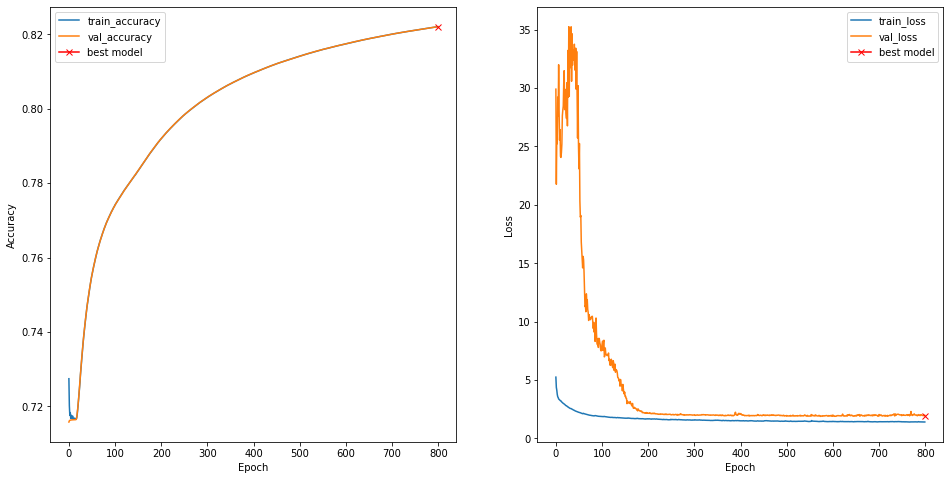

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.plot(results.history['accuracy'], label='train_accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(1,2,2)
plt.plot(results.history['loss'], label='train_loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.plot(np.argmax(results.history["val_accuracy"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# weight tốt nhất
model.load_weights('/content/drive/MyDrive/KLTN/model_save/model_isbi_u2_net.h5')

# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/KLTN/model_save/model_isbi_u2_net.h5', compile=False)

In [ ]:
# Độ chính xác trên tập valid
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 1s 750ms/step - loss: 1.9853 - accuracy: 0.8220


[1.9853177070617676, 0.8220474123954773]

### Thử nghiệm mô hình

1/1 [==============================] - 1s 654ms/step
(18, 256, 256, 1)


Text(0.5, 1.0, 'image predict')

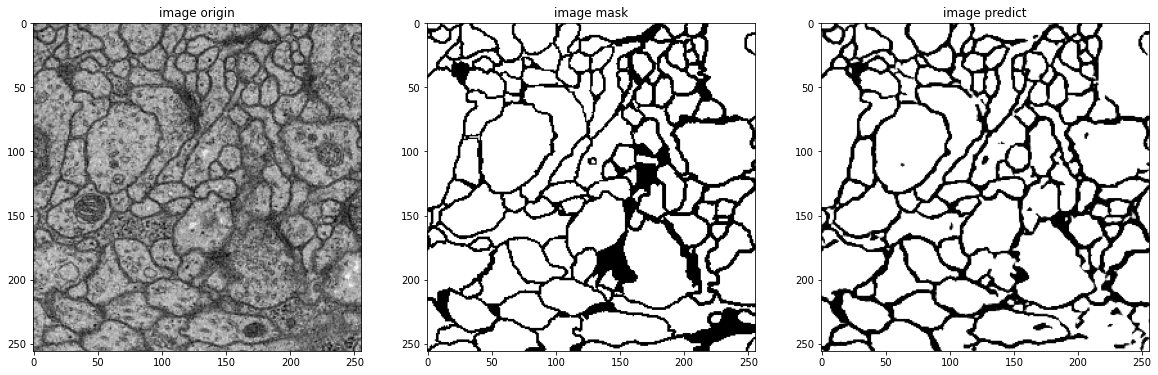

In [ ]:
import random
idx_rd = random.randint(0, len(X_valid)-1)
pred_img = model.predict(X_valid, verbose=1)


print(pred_img[0].shape)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(X_valid[idx_rd].squeeze(), cmap='gray')
ax[0].set_title('image origin')

ax[1].imshow(y_valid[idx_rd].squeeze(), cmap='gray')
ax[1].set_title('image mask')

ax[2].imshow(pred_img[0][idx_rd].squeeze(), cmap='gray')
ax[2].set_title('image predict')

# pred_bn = (pred_img[0][0] > 0.5).astype(np.uint8)

# ax[3].imshow(pred_bn.squeeze(), cmap='gray')
# ax[3].set_title('predict binary')

1/1 [==============================] - 1s 1s/step
(7, 1, 256, 256, 1)
0.9983132
0.0037760253


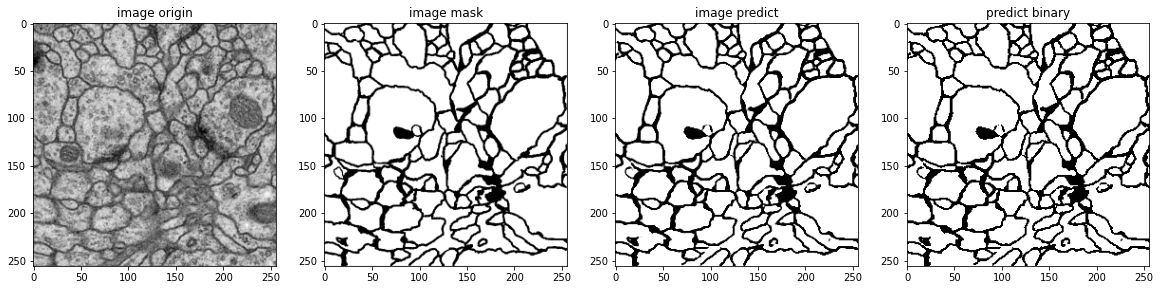

In [ ]:
img_test = np.array(Image.open('/content/drive/MyDrive/KLTN/data_unet/train_isbi/train-volume.tif').convert('L'))
img_test = resize(img_test, (256, 256, 1), mode = 'constant', preserve_range = True)

mask_test = np.array(Image.open('/content/drive/MyDrive/KLTN/data_unet/train_isbi/train-labels.tif').convert('L'))
mask_test = resize(mask_test, (256, 256, 1), mode = 'constant', preserve_range = True)

arr_img = [img_test]
arr_img = np.array(arr_img)/255

# predict
pred_img_test = model.predict(arr_img, verbose=1)

print(pred_img_test.shape)

for i in range(len(pred_img_test)):
  img = array_to_img(pred_img_test[i][0])
  img.save('/content/drive/MyDrive/KLTN/image_save/u2_net/img'+str(i)+'.png')


fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(img_test.squeeze(), cmap='gray')
ax[0].set_title('image origin')

ax[1].imshow(mask_test.squeeze(), cmap='gray')
ax[1].set_title('image mask')

ax[2].imshow(pred_img_test[0][0].squeeze(), cmap='gray')
ax[2].set_title('image predict')

# pred_bn_test = (pred_img_test[0][0] < 0.5).astype(np.uint8)
pred_bn_test = np.where(pred_img_test[0][0] > 0.5, 1, 0)
ax[3].imshow(pred_bn_test.squeeze(), cmap='gray')
ax[3].set_title('predict binary')

print(np.amax(pred_img_test[0][0]))
print(np.amin(pred_img_test[0][0]))